In [2]:
import os
import sys
import cv2
import math
import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
   
import torch
from torch.utils.data.dataloader import DataLoader 
from torchvision import transforms
    
from Net.hpatches_dataset import (HPatchesDataset, Grayscale, 
                                  Normalize, Rescale, ToTensor)
from Net.exp_env.analyze_config import cfg
from Net.utils.image_utils import *
from Net.utils.eval_utils import torch2cv, to_cv2_keypoint
from Net.utils.model_utils import sample_descriptors

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def plot_figures(figures, nrows = 1, ncols=1):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
    for ind,title in zip(range(len(figures)), figures):
        axeslist.ravel()[ind].imshow(figures[title], cmap=plt.jet())
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
        
    plt.tight_layout() # optional

In [4]:
torch.manual_seed(9)
dataset = HPatchesDataset(root_path=cfg.DATASET.view.root,
                              csv_file=cfg.DATASET.view.analyze_csv,
                              transform=transforms.Compose([
                                  Grayscale(),
                                  Rescale((960, 1280)),
                                  Rescale((320, 640)),
                                  ToTensor(),
                              ]), include_sources=True)

loader = DataLoader(dataset, 1, False)

In [5]:
batch = next(loader.__iter__())
image1 = batch['image1']
image2 = batch['image2']
homo12 = batch['homo12']
homo21 = batch['homo21']

grid_size = 8

desc1 = torch.load('desc1.torch')
desc2 = torch.load('desc2.torch')

kp1 = torch.load('kp1.torch')
kp2 = torch.load('kp2.torch')

w_kp1 = warp_keypoints(kp1, homo12)
w_kp2 = warp_keypoints(kp2, homo21)

kp1_desc = sample_descriptors(desc1, kp1, grid_size)
kp2_desc = sample_descriptors(desc2, kp2, grid_size)


In [6]:
w_kp1_grid = w_kp1.float().unsqueeze(1)
kp2_grid = kp2.float().unsqueeze(0)

grid_dist = torch.norm(w_kp1_grid - kp2_grid, dim=-1)
radius = math.sqrt(grid_size**2 / 2)
neighbour_mask = (grid_dist <= 2 * radius + 0.1).float()

anchor = kp1_desc.unsqueeze(1)
positive = kp2_desc.unsqueeze(0)

desc_dist = torch.norm(anchor - positive, dim=-1)
desc_dist += neighbour_mask * 5

negative, idx = desc_dist.min(dim=-1)


In [19]:
cv_image2 = torch2cv(image2)

cv_kp2 = to_cv2_keypoint(kp2)
cv_w_kp1 = to_cv2_keypoint(w_kp1[0].unsqueeze(0))
cv_neg_kp2 = to_cv2_keypoint(kp2[idx[0]].unsqueeze(0))

cv_neigh = neighbour_mask.nonzero()
print(cv_neigh[:4, 1])
cv_neigh = to_cv2_keypoint(kp2.index_select(dim=0, index=cv_neigh[:4, 1]))

cv_image2_kp = cv2.drawKeypoints(cv_image2, 
                                  cv_kp2, None, color=(0, 255, 0))
cv_image2_kp = cv2.drawKeypoints(cv_image2_kp, 
                                  cv_w_kp1, None, color=(255, 0, 0))
cv_image2_kp = cv2.drawKeypoints(cv_image2_kp, 
                                  cv_neg_kp2, None, color=(0, 0, 255))
cv_image2_kp = cv2.drawKeypoints(cv_image2_kp,
                                 cv_neigh, None, color=(255, 255))


cv_image2 = cv_image2.repeat(3, axis=2)


tensor([ 6, 15, 17, 27])


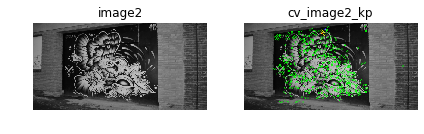

In [20]:
plot_figures({'image2': cv_image2,
              'cv_image2_kp': cv_image2_kp
              }, 1, 2)

plt.imsave('pictures/image2.png', cv_image2)
plt.imsave('pictures/cv_image2_kp.png', cv_image2_kp)


In [33]:

grid2 = create_coordinates_grid(desc2.size()) * grid_size + grid_size // 2

kp_grid = w_kp1[:, [3, 2]].float().unsqueeze(0).unsqueeze(2).unsqueeze(2)
grid2 = grid2.unsqueeze(1)

grid_dist = torch.norm(kp_grid - grid2, dim=-1)

radius = math.sqrt(grid_size**2 / 2)
pos_matches = (grid_dist <= radius + 0.1).float()
neighbour_mask = (grid_dist <= 2 * radius + 0.1).float()
neg_matches = 1 - neighbour_mask


In [41]:
cv_image1 = torch2cv(image1)
cv_image2 = torch2cv(image2)

cv_kp1 = to_cv2_keypoint(kp1)
cv_kp2 = to_cv2_keypoint(kp2)

cv_w_kp1 = to_cv2_keypoint(w_kp1)

cv_pos_matches = pos_matches.nonzero()
cv_pos_matches[:, 2:] = cv_pos_matches[:, 2:] * grid_size + grid_size // 2
cv_pos_matches = to_cv2_keypoint(cv_pos_matches)

cv_neighbours = neighbour_mask.nonzero()
cv_neighbours[:, 2:] = cv_neighbours[:, 2:] * grid_size + grid_size // 2
cv_neighbours = to_cv2_keypoint(cv_neighbours)

cv_grid2 = grid2.view(-1, 2)[:, [1, 0]]
cv_grid2 = torch.cat((torch.zeros((cv_grid2.size(0), 2)), cv_grid2), dim=1)
cv_grid2 = to_cv2_keypoint(cv_grid2)

cv_image1_kp1 = cv2.drawKeypoints(cv_image1, 
                                  cv_kp1, None, color=(0, 255, 0))
cv_image2_kp2 = cv2.drawKeypoints(cv_image2, 
                                  cv_kp2, None, color=(0, 255, 0))

cv_image2_grid2 = cv2.drawKeypoints(cv_image2, 
                                    cv_grid2, None, color=(0, 255, 0))
cv_image2_w_kp1 = cv2.drawKeypoints(cv_image2_grid2,
                                    cv_w_kp1, None, color=(255, 0, 0))

cv_image2_pos_matches = cv2.drawKeypoints(cv_image2_w_kp1,
                                      cv_pos_matches, None, color=(0, 0, 255))
cv_image2_neighbours = cv2.drawKeypoints(cv_image2_w_kp1,
                                         cv_neighbours, None, color=(0, 0, 255))

cv_image1 = cv_image1.repeat(3, axis=2)
cv_image2 = cv_image2.repeat(3, axis=2)


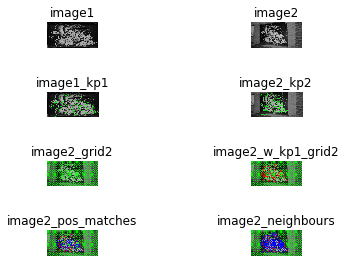

In [37]:
plot_figures({'image1': cv_image1, 
              'image2': cv_image2,
              'image1_kp1': cv_image1_kp1,
              'image2_kp2': cv_image2_kp2,
              'image2_grid2': cv_image2_grid2,
              'image2_w_kp1_grid2': cv_image2_w_kp1,
              'image2_pos_matches': cv_image2_pos_matches,
              'image2_neighbours': cv_image2_neighbours
              }, 4, 2)

plt.imsave('pictures/image1.png', cv_image1)
plt.imsave('pictures/image2.png', cv_image2)
plt.imsave('pictures/image1_kp1.png', cv_image1_kp1)
plt.imsave('pictures/image2_kp2.png', cv_image2_kp2)
plt.imsave('pictures/image2_grid2.png', cv_image2_grid2)
plt.imsave('pictures/image2_w_kp1.png', cv_image2_w_kp1)
plt.imsave('pictures/cv_image2_pos_matches.png', cv_image2_pos_matches)
plt.imsave('pictures/cv_image2_neighbours.png', cv_image2_neighbours)
